### Formulas and Discriptions

$$\text{Perplexity} = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(w_i \mid w_{i-n+1}^{i-1})\right)$$


### initial test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import softmax
from functools import partial
from tqdm import tqdm
import os, random 
import math

NGRAM_RESULTS_DIR = os.path.join("results", "ngram")
TOKENIZER_RESULTS_DIR = os.path.join("results", "tokenizer")
os.makedirs(NGRAM_RESULTS_DIR, exist_ok=True)
os.makedirs(TOKENIZER_RESULTS_DIR, exist_ok=True)

In [2]:
from ngram_engine import NGramEngine, check_context_distribution, plot_ngram_probs
from bpe_hf import train_bytelevel_bpe, load_tokenizer, SPECIAL_TOKENS
from ngram_engine import perplexity_over_n, plot_perplexity_and_n_grams_combinations

In [3]:
# testing
N = 3
interpolate = True
lambdas = softmax([7, 4, 2])
get_all_probs = True

model = NGramEngine(N)

example_text = """
<s> simple simple simple example of some simple example text for some simple example code </s>
"""


model.fit(example_text, lambdas, pad_token="<s>")

print("total ngram vocab size: ",model.total_vocab_size)
print("model vocab: ", model.vocab)
print("interpolation lambdas: ", model.lambdas)
display(model.counts)
prob, all_probs = model.get_n_gram_prob("of some simple", interpolate, verbose=True, get_all_probs=get_all_probs) 
print("ngram prob: ", prob, "\nall probs: ", all_probs)

generated_text = model.generate(list("of some simple".split(" ")), max_new_tokens=100, mode="argmax")
generated_text = model.generate("of some simple", max_new_tokens=100, mode="sample",
                                stop_tokens=["</s>"],)
print("Generated text: ", generated_text) 

total ngram vocab size:  9
model vocab:  ('example', 'simple', '</s>', 'of', 'code', 'for', '<s>', 'some', 'text')
interpolation lambdas:  [0.94649912 0.04712342 0.00637746]


{0: Counter({(): 16}),
 1: Counter({('simple',): 5,
          ('example',): 3,
          ('some',): 2,
          ('<s>',): 1,
          ('of',): 1,
          ('text',): 1,
          ('for',): 1,
          ('code',): 1,
          ('</s>',): 1}),
 2: Counter({('simple', 'example'): 3,
          ('simple', 'simple'): 2,
          ('some', 'simple'): 2,
          ('<s>', 'simple'): 1,
          ('example', 'of'): 1,
          ('of', 'some'): 1,
          ('example', 'text'): 1,
          ('text', 'for'): 1,
          ('for', 'some'): 1,
          ('example', 'code'): 1,
          ('code', '</s>'): 1}),
 3: Counter({('some', 'simple', 'example'): 2,
          ('<s>', 'simple', 'simple'): 1,
          ('simple', 'simple', 'simple'): 1,
          ('simple', 'simple', 'example'): 1,
          ('simple', 'example', 'of'): 1,
          ('example', 'of', 'some'): 1,
          ('of', 'some', 'simple'): 1,
          ('simple', 'example', 'text'): 1,
          ('example', 'text', 'for'): 1,
        

Query: ('of', 'some', 'simple')
Prefix:('of', 'some')
N=3, Num: 2, Denom: 10, Prob: 0.2
Query: ('some', 'simple')
Prefix:('some',)
N=2, Num: 3, Denom: 11, Prob: 0.2727272727272727
Query: ('simple',)
Prefix:()
N=1, Num: 6, Denom: 25, Prob: 0.24
ngram prob:  0.2412871224675459 
all probs:  [0.24       0.27272727 0.2       ]
Generated text:  ['of', 'some', 'simple', 'simple', 'simple', '<s>', 'example', 'code', 'code', 'text', 'for', 'for', '<s>', 'code', 'example', 'simple', 'text', '</s>']


### Tokenizer and data preparation

In [4]:
data_dir = "../data/"
train_file = "Shakespeare_clean_train.txt"
train_file = os.path.join(data_dir, train_file)
test_file = "Shakespeare_clean_test.txt"
test_file = os.path.join(data_dir, test_file)
val_file = "Shakespeare_clean_valid.txt"
val_file = os.path.join(data_dir, val_file)

with open(train_file, "r", encoding="utf-8") as f:
    train_text = f.read().strip()

with open(test_file, "r", encoding="utf-8") as f:
    test_text = f.read().strip()

with open(val_file, "r", encoding="utf-8") as f:
    val_text = f.read().strip()

In [5]:
N_MERGES = 1200
MIN_FREQ = 2
SPECIAL_TOKENS = SPECIAL_TOKENS.copy()
PAD_TOKEN = SPECIAL_TOKENS.get("pad", "<pad>")
BOS_TOKEN = SPECIAL_TOKENS.get("bos", "<bos>")
EOS_TOKEN = SPECIAL_TOKENS.get("eos", "<eos>")

bpe_tokenizer = train_bytelevel_bpe(files=[train_file],
                                merges=N_MERGES, 
                                min_frequency=MIN_FREQ,
                                name=f"bpe_shakespeare_{N_MERGES}",
                                special_tokens=SPECIAL_TOKENS,)
# bind encode to bpe_tokenizer.encode with add_special_tokens=False
encode = partial(bpe_tokenizer.encode, add_special_tokens=False)
decode = bpe_tokenizer.decode
vocab_size = bpe_tokenizer.get_vocab_size()
print("BPE tokenizer vocab: ", bpe_tokenizer.get_vocab())
print("vocab size: ", vocab_size)

PAD_TOKEN_ID = bpe_tokenizer.token_to_id(PAD_TOKEN) 
BOS_TOKEN_ID = bpe_tokenizer.token_to_id(BOS_TOKEN)
EOS_TOKEN_ID = bpe_tokenizer.token_to_id(EOS_TOKEN)

train_ids = encode(train_text).ids
test_ids = encode(test_text).ids
val_ids = encode(val_text).ids

print("train text charachters length: ", len(train_text))
print("train text words count: ", len(train_text.split()))
print("train ids length: ", len(train_ids))
print("train text first 100 chars: ", train_text[:100])
print("train ids first 100 ids: ", train_ids[:100])
print("train ids first 100 individual tokens: ", [bpe_tokenizer.id_to_token(i) for i in train_ids[:100]]) 





BPE tokenizer vocab:  {'Ġstr': 868, 'let': 997, 'Ġwhat': 457, 'CRANTZ': 1386, 'AN': 592, 'ĠW': 311, 'Ġbring': 1255, 'Ġsc': 807, 'ought': 1065, 'Ġdear': 975, 'ĠSecond': 1191, 'Ò': 146, 'Ġaw': 723, 'LO': 521, 'air': 1291, 'IO': 453, 'Ġsea': 1456, 'Ġw': 266, 'IUS': 399, 'ks': 1179, 'BARBUS': 910, 'ors': 1019, 'ĠHamlet': 1115, 'ĠCassio': 1076, 'ĠYet': 1421, 'ceive': 1222, 'et': 310, 'Ġagainst': 1302, 'ARI': 1380, 'ĠCL': 566, 'Ġwoman': 1228, 'Ġsl': 841, 'Ġbet': 775, 'Ġcons': 1129, 'f': 73, 'ë': 171, 'AMLET': 543, 'Ġmake': 614, 'Ø': 152, 'Ġfur': 1295, 'Ð': 144, 'Ġeyes': 833, 'å': 165, 'LUS': 1336, 'ool': 924, 'Ġletter': 1382, '{': 94, 'Ġpe': 1020, 'ou': 264, 'Ġsuch': 612, 'Ġgu': 1329, 'ong': 526, 'Ġcould': 965, 'ĠFare': 1367, 'Ġout': 609, 'ES': 470, 'rant': 1124, 'fect': 1423, 'Ġsay': 528, 'ĠCAPULET': 1272, 'ĠQU': 949, 'Ġwor': 584, 'Ġsu': 421, 'ittle': 1271, 'ĠLAERTES': 1359, 'Ġt': 260, 'Ġthose': 1141, 'ck': 406, '<pad>': 0, 'É': 137, 'Ġmany': 1090, 'Ġgentle': 845, 'ĠAy': 894, 'Ġwould': 5

### inspect ngram model

In [6]:
TRAIN_TEXT = train_ids
N = 4
INTERPOLATE = True

lambdaBias = 0.8
weights = np.linspace(1 - lambdaBias, lambdaBias, N) * 8
lambdas = softmax(weights)

model = NGramEngine(N)
model.fit(TRAIN_TEXT, lambdas, pad_token=BOS_TOKEN_ID)

print(f"N = {N}\nlambdaBias = {lambdaBias:.2f}, lambdas = {lambdas}")
print("prob of non-existened n-gram and (n-1)-gram :", 1 / model.total_vocab_size) 
print("vocab size: ", model.total_vocab_size)
print("num all text tokens: ", len(TRAIN_TEXT))

context = "romeo and juliet are"
context_ids = encode(context).ids
print("context for next token probs: ", context)

probs, tokens, all_probs = model.get_next_token_probs(context_ids, interpolate=INTERPOLATE, get_all_probs=True)
df = pd.DataFrame({'token_ids': tokens, 'prob': probs})
df['token'] = df['token_ids'].apply(lambda x: decode([int(x)]))

for i in range(N):
    df[f'{i+1}-gram prob'] = all_probs[:,i]

df = df.sort_values('prob', ascending=False).reset_index(drop=True)
display(df.head(10))

# generate text
context = "romeo and juliet are"
context_ids = encode(context).ids
print("context for text generation: ", context)
generated_text = model.generate(context_ids, max_new_tokens=100, mode="sample")
print("Generated text: ", decode(generated_text))

N = 4
lambdaBias = 0.80, lambdas = [0.00657912 0.0325866  0.16140249 0.79943178]
prob of non-existened n-gram and (n-1)-gram : 0.0008431703204047217
vocab size:  1186
num all text tokens:  293093
context for next token probs:  romeo and juliet are


,token_ids,prob,token,1-gram prob,2-gram prob,3-gram prob,4-gram prob
0,331,0.001602,not,0.005447,0.023215,0.000843,0.000843
1,294,0.001448,you,0.007809,0.017992,0.000843,0.000843
2,15,0.001416,",",0.051791,0.008125,0.000843,0.000843
3,271,0.001325,the,0.015088,0.012768,0.000843,0.000843
4,556,0.001177,they,0.001118,0.011027,0.000843,0.000843
5,17,0.001172,.,0.023423,0.006384,0.000843,0.000843
6,262,0.001112,a,0.008458,0.007545,0.000843,0.000843
7,427,0.001107,all,0.002059,0.008706,0.000843,0.000843
8,313,0.001064,in,0.006997,0.006384,0.000843,0.000843
9,298,0.001060,p,0.003436,0.006965,0.000843,0.000843


context for text generation:  romeo and juliet are
Generated text:   romeo and juliet are disats ffect Th shbleought awayird NurseakA tonguegW jeral Ufect busairore fatherers6vers do first nonenterIAuection If There d sommen Wellish his pass Venoth let SCENE forth mur Caesarade BRUTUS serachirit ru'd Aside't B like c tAL sleepeet bear face neUL moTis QU accintgh thereUishcond? Jew sir in furakeUL kn smree trueleepis Who yourovepeav eyes Would


In [7]:
# get all n-gram probabilities for different n-grams
print_top_k = 10
n_gram_probs_dict = {}
for n in range(1, N + 1):
    n_gram_probs_dict[n] = oneGram_probs = {key: model.get_n_gram_prob(key, interpolate=INTERPOLATE, n=n) for key in model.get_n_grams(TRAIN_TEXT, n)}
    n_gram_probs_dict[n] = {tuple([decode([int(i)]) for i in k]): v for k, v in n_gram_probs_dict[n].items()}
    print(f"num all {n}-grams: ", model.counts[n].total())
    print(f"Distinct {n}-grams: ", len(n_gram_probs_dict[n]))
    print(f"top {print_top_k} {n}-grams (decoded): ", [(decode(i[0]), i[1]) for i in model.counts[n].most_common(print_top_k)])

num all 1-grams:  293093
Distinct 1-grams:  1186
top 10 1-grams (decoded):  [(',', 15240), ('.', 6892), (' the', 4439), (' I', 4146), ('s', 3735), (' and', 3268), (' to', 3087), (';', 2961), (':', 2800), (' of', 2753)]
num all 2-grams:  293092
Distinct 2-grams:  65694
top 10 2-grams (decoded):  [(', and', 1015), (', I', 806), (', And', 589), ('s,', 536), (', my', 379), (' I am', 346), (' I have', 324), (' I will', 306), (' in the', 300), ('. Enter', 295)]
num all 3-grams:  293091
Distinct 3-grams:  195894
top 10 3-grams (decoded):  [(', my lord', 217), (', sir,', 118), ('. MARK ANTONY', 106), (' my lord,', 86), ('. Exeunt SCENE', 83), (' my lord.', 83), (" o'er", 77), (', I will', 74), (", I'll", 73), ('. DOMITIUS ENOBARBUS', 70)]
num all 4-grams:  293090
Distinct 4-grams:  256388
top 10 4-grams (decoded):  [(', my lord.', 75), (', my lord,', 67), (' OPHELIA', 52), (' DEMETR', 51), ('METRIUS', 51), (' MALCOL', 51), ('LCOLM', 51), (' LAUNCELOT', 51), (' Tybalt', 51), (' Re-enter', 50)]


sum of probabilities for 1-gram:  1.0000000000000002
sum of probabilities for 2-gram:  196.554275761653
sum of probabilities for 3-gram:  643.7454992128714
sum of probabilities for 4-gram:  617.4792431951504


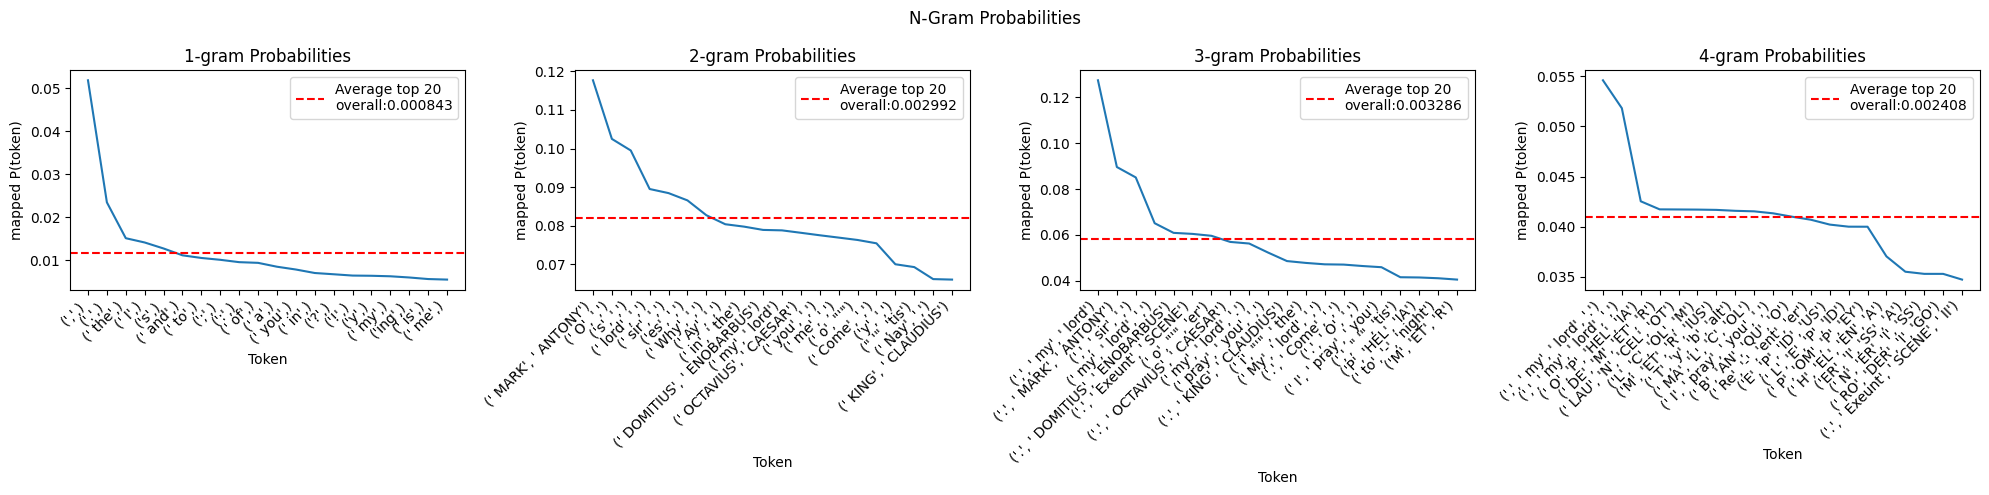

In [8]:
n_rows = int(np.floor(N*0.4))
n_cols = N // n_rows + N%2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*5))   
axs = axs.flatten()
plt.suptitle('N-Gram Probabilities')

plot_top_n = 20
for n in range(1, N + 1):
    ax = plot_ngram_probs(n_gram_probs_dict[n], top_n=plot_top_n,
                        title=f'{n}-gram Probabilities', ax=axs[n-1])
    
plt.legend()
plt.tight_layout()
plt.show()

#### ensure margilizing over conditional probabilities sums to 1

In [9]:
n = 3
model_test = NGramEngine(n)
lambdas = softmax(np.linspace(1, n , n))
# lambdas = softmax(np.array([0.1, 0.7, 0.2]))

model_test.fit(TRAIN_TEXT, lambdas, pad_token=BOS_TOKEN_ID)

print("lambdas: ", model_test.lambdas, "\nsum lambdas: ", np.sum(model_test.lambdas))

out1 = check_context_distribution(model_test, encode("the").ids, interpolate=True)
out2 = check_context_distribution(model_test, encode("to be").ids, interpolate=True)
out3 = check_context_distribution(model_test, encode("romeo and").ids, interpolate=False)

lambdas:  [0.09003057 0.24472847 0.66524096] 
sum lambdas:  0.9999999999999999

Context: [271]
Sum of probs = 0.876250
Top 10 tokens:
  21         0.000767
  25         0.000767
  27         0.000767
  45         0.000767
  484        0.000767
  543        0.000767
  683        0.000767
  692        0.000767
  898        0.000767
  1085       0.000767

Context: [296, 315]
Sum of probs = 1.000000
Top 10 tokens:
  262        0.009429
  15         0.008608
  445        0.005453
  68         0.005086
  271        0.005064
  313        0.004731
  277        0.004504
  17         0.004380
  848        0.004236
  266        0.004223

Context: [557, 362, 82, 297]
Sum of probs = 1.000000
Top 10 tokens:
  364        0.004163
  322        0.002498
  365        0.002498
  271        0.001665
  344        0.001665
  345        0.001665
  366        0.001665
  418        0.001665
  1026       0.001665
  1280       0.001665


### interactive playground

In [12]:
import numpy as np
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from scipy.special import softmax

TRAIN_TEXT = train_ids
CASHED_MODEL = {}

train_output = widgets.Output()
generate_output = widgets.Output()

def explore_train_model(N, train_context, lambdaBias, lambdaScale):
    global TRAIN_TEXT
    with train_output:
        train_output.clear_output(wait=True)

        weights = np.linspace(1 - lambdaBias, lambdaBias, N) * lambdaScale
        lambdas = softmax(weights)

        model = NGramEngine(N)
        model.fit(TRAIN_TEXT, lambdas, pad_token=BOS_TOKEN_ID)
        
        CASHED_MODEL["model"] = model

        print(f"lambdas (1-gram → {N}-gram):", np.round(lambdas, 3))
        print("total vocab size:", model.total_vocab_size)
        print("-" * 40)

        print("next token probabilities:")
        # for context in ["<s>", "example text for some simple"]:
        # for context in ["blabla. <s>", "example text for some simple"]:
        context = train_context
        context_ids = encode(context).ids
        # context = ' '.join([str(token) for token in context])

        next_token_probs, tokens, all_probs = model.get_next_token_probs(context_ids, interpolate=True, get_all_probs=True)
        df = pd.DataFrame({'token_ids': tokens, 'prob': next_token_probs})
        df['token'] = df['token_ids'].apply(lambda x: decode([int(x)]))
        # replace spaces by <space> in each token that has spaces in it
        df['token'] = df['token'].apply(lambda x: x.replace(' ', '<space>'))

        for i in range(N):
            df[f'{i+1}-gram prob'] = all_probs[:,i]

        df = df.sort_values('prob', ascending=False).reset_index(drop=True)

        print(f"context: {context}")
        display(df.head(10))


def explore_generate_text(b):
    with generate_output:
        model = CASHED_MODEL.get("model")
        if model is None:
            print("No model cached. Please run the training first.")
            return
        
        generate_output.clear_output(wait=True)
            
        max_pred = max_pred_slider.value
        gen_mode = gen_mode_slider.value
        temperature = temperature_slider.value
        top_k = top_k_slider.value
        top_p = top_p_slider.value
        repeat_penalty = repetition_penalty_slider.value
        context = gen_context.value

        context_ids = encode(context).ids
        # context = ' '.join([str(token) for token in context])

        print("-" * 40)
        print("Generated text:")
        gen_text_ids = model.generate(context_ids,
                                      max_len=max_pred,
                                      mode=gen_mode,
                                      temperature=temperature,
                                      top_k=top_k,
                                      top_p=top_p,
                                      repetition_penalty=repeat_penalty)

        print("Generated text IDs:", type(gen_text_ids))
        gen_text = decode(gen_text_ids)
        
        print(f"Context: {context}")
        print(gen_text)
        
        output_box.value = gen_text
        display(output_box)

n_slider = widgets.IntSlider(
    value=3, min=1, max=8, step=1,
    description='N', continuous_update=False
)

lambdaBias_slider = widgets.FloatSlider(
    value=0.8, min=0.0, max=1.0, step=0.05,
    description='lambdaBias', continuous_update=False
)

lambdaScale_slider = widgets.FloatSlider(
    value=8, min=1, max=20, step=1,
    description='lambdaScale', continuous_update=False
)

train_context_input = widgets.Text(
    value="and here comes",
    description="Next-word context:",
    layout=widgets.Layout(width="100%")
)

max_pred_slider = widgets.IntSlider(
    value=80, min=1, max=500, step=10,
    description='Max Predictions', continuous_update=False
)   

gen_mode_slider = widgets.ToggleButtons(
    options=['argmax', 'sample'],
    description='Mode',
    value='argmax',
    style={'description_width': 'initial'}
)

temperature_slider = widgets.FloatSlider(
    value=0.8, min=0.0, max=8.0, step=0.1,
    description='Temperature', continuous_update=False
)

top_k_slider = widgets.IntSlider(
    value=50, min=0, max=100, step=1,
    description='Top K', continuous_update=False
)

top_p_slider = widgets.FloatSlider(
    value=0.0, min=0.0, max=1.0, step=0.01,
    description='Top P', continuous_update=False
)

repetition_penalty_slider = widgets.FloatSlider(
    value=1.0, min=0.0, max=1.0, step=0.05,
    description='Repeat Penalty', continuous_update=False
)

gen_context = widgets.Text(
    value="and here comes",
    description='Context:',
    layout=widgets.Layout(width='100%')
)

output_box = widgets.Textarea(
        value="",
        layout=widgets.Layout(
            width='100%',
            height='300%',
            padding='10px',
            font_family='monospace',
            overflow='auto',
        ),
        style={
            'description_width': 'initial',
            'font_family': 'monospace',
        },
        disabled=True
    )

generate_button = widgets.Button(description='Generate Text', button_style='info')
generate_button.on_click(explore_generate_text)

prompt_box = widgets.VBox([gen_context, gen_mode_slider,
                            max_pred_slider, temperature_slider, top_k_slider, top_p_slider, repetition_penalty_slider,
                            generate_button, output_box])

complete_box = widgets.VBox([
    widgets.HTML("<h3>## Model Configuration</h3>"),
    lambdaBias_slider,
    lambdaScale_slider,
    n_slider,
    train_context_input,
    train_output,
    widgets.HTML("<h3>## Text Generation</h3>"),
    prompt_box
])

# Launch both areas
train_ui = widgets.interactive_output(
    explore_train_model,
    {'lambdaBias': lambdaBias_slider, 'lambdaScale': lambdaScale_slider,
     'N': n_slider, 'train_context': train_context_input}
)

display(complete_box)

display(train_ui)


Output()

### n-gram and tokenizer analyses

#### Perplexity over n

,n,ppl_val,bpt_val,nats_per_tok_val,ppl_train,bpt_train,nats_per_tok_train,num_n_grams
0,1,491.456478,8.940920,6.197373,497.156008,8.957555,6.208904,1186
1,2,183.050890,7.516101,5.209764,155.307262,7.278981,5.045405,65694
2,3,545.526565,9.091506,6.301752,356.659020,8.478402,5.876780,195894
3,4,843.821188,9.720794,6.737941,496.078916,8.954426,6.206735,256388
4,5,961.465694,9.909092,6.868459,551.380078,9.106903,6.312424,277341
5,6,1004.526844,9.972300,6.912272,574.327741,9.165730,6.353200,285491
6,7,1020.646725,9.995268,6.928192,583.855361,9.189467,6.369653,289028
7,8,1027.570461,10.005022,6.934953,587.856595,9.199320,6.376483,290604
8,9,1030.551743,10.009201,6.937850,589.898414,9.204323,6.379950,291419
9,10,1032.071450,10.011327,6.939323,591.085059,9.207222,6.381960,291913


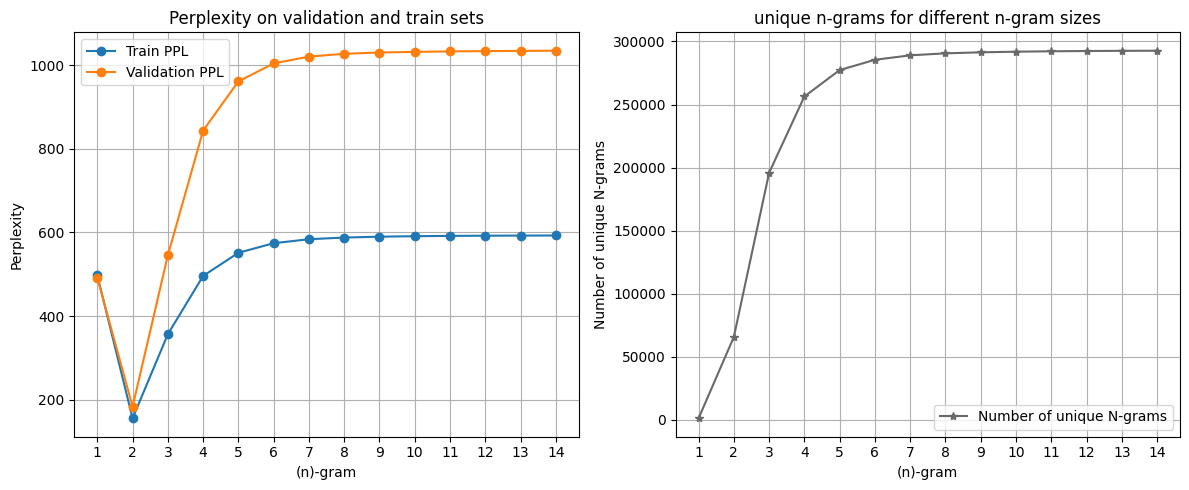

In [11]:
n_range = 15
TRAIN_TEXT = train_ids
VAL_TEXT = val_ids

ppl_results = perplexity_over_n(n_range, train_ids=TRAIN_TEXT, val_ids=VAL_TEXT ,verbose=False)
ppl_results = pd.DataFrame(ppl_results, index=None)
display(ppl_results)
plot_perplexity_and_n_grams_combinations(ppl_results, save_path=os.path.join(NGRAM_RESULTS_DIR, "ppl_over_n_grams.png"))

#### Tokenizer statistics

##### Heaps' law and corpus statistics

In [13]:
from bpe_hf import fit_tokenizer_params, plot_heaps_and_metrics,\
                _np_softmax, avg_token_chr_length, compression_ratio_agnostic,\
                heaps_curve, fit_heaps_law, plot_heaps, vocab_utilization

#### Tokenizer parameters search

In [17]:
n_merges_grid = list(range(10, 201, 20)) +\
                list(range(300, 2001, 100)) +\
                list(range(2500, 15501, 2000))  

df_tokenizer_search = fit_tokenizer_params(
    train_text_path=train_file,
    val_text_path=val_file,
    merges_grid=n_merges_grid,
    tokenizer_trainer=train_bytelevel_bpe,
    special_tokens=SPECIAL_TOKENS,
    min_frequency=2,
    target_tokens=None,
    heaps_step=200,
    verbose=False,
    plot_heaps=False,
    csv_log_path=os.path.join(TOKENIZER_RESULTS_DIR, "tokenizer_search_results.csv")
    )
display(df_tokenizer_search.head(10))




Saved tokenizer to bpe_tok/bpe_k10.json | vocab=270 (requested merges=10)



Saved tokenizer to bpe_tok/bpe_k30.json | vocab=290 (requested merges=30)



Saved tokenizer to bpe_tok/bpe_k50.json | vocab=310 (requested merges=50)



Saved tokenizer to bpe_tok/bpe_k70.json | vocab=330 (requested merges=70)



Saved tokenizer to bpe_tok/bpe_k90.json | vocab=350 (requested merges=90)



Saved tokenizer to bpe_tok/bpe_k110.json | vocab=370 (requested merges=110)



Saved tokenizer to bpe_tok/bpe_k130.json | vocab=390 (requested merges=130)



Saved tokenizer to bpe_tok/bpe_k150.json | vocab=410 (requested merges=150)



Saved tokenizer to bpe_tok/bpe_k170.json | vocab=430 (requested merges=170)



Saved tokenizer to bpe_tok/bpe_k190.json | vocab=450 (requested merges=190)



Saved tokenizer to bpe_tok/bpe_k300.json | vocab=560 (requested merges=300)



Saved tokenizer to bpe_tok/bpe_k400.json | vocab=660 (requested merges=400)



Saved tokenizer to bpe_tok/bpe_k500.json | vocab=760 (reque

,merges,vocab_size,K,beta,R2,util_now,compression_ratio,chars_per_token,tokens_per_1k_chars,N_star,...,train_beta,train_R2,train_util_now,train_compression_ratio,train_chars_per_token,train_tokens_per_1k_chars,train_N_star,train_V_end,train_V_hat_star,train_util_star
0,10,270,45.460134,0.040956,0.874586,0.262963,0.000086,1.128813,885.886087,461870,...,0.012142,0.847700,0.285185,0.000011,1.132131,883.289913,3817685,77,73.957492,0.273917
1,30,290,64.704142,0.031746,0.871785,0.313793,0.000112,1.296283,771.436518,402200,...,0.009464,0.847727,0.334483,0.000014,1.299522,769.513572,3325930,97,93.943384,0.323943
2,50,310,82.652847,0.027771,0.824251,0.358065,0.000138,1.427517,700.516912,365225,...,0.008023,0.836800,0.377419,0.000018,1.432905,697.883215,3016335,117,114.013957,0.367787
3,70,330,91.702832,0.033880,0.805855,0.396970,0.000164,1.527563,654.637346,341305,...,0.007654,0.854641,0.415152,0.000021,1.535403,651.294966,2814975,137,134.298638,0.406966
4,90,350,102.808897,0.036842,0.766422,0.431429,0.000191,1.614983,619.201519,322830,...,0.006635,0.854943,0.448571,0.000024,1.621149,616.846594,2666085,157,154.291337,0.440832
5,110,370,109.806155,0.042773,0.742466,0.462162,0.000219,1.686883,592.809260,309070,...,0.007360,0.884360,0.478378,0.000027,1.695308,589.863308,2549460,177,174.914757,0.472743
6,130,390,116.687716,0.047904,0.717155,0.489744,0.000246,1.750663,571.212107,297810,...,0.006585,0.884519,0.505128,0.000031,1.760792,567.926157,2454645,197,194.908259,0.499765
7,150,410,120.700803,0.054493,0.701290,0.514634,0.000274,1.809227,552.722181,288170,...,0.005957,0.884646,0.529268,0.000034,1.819518,549.596032,2375420,217,214.902816,0.524153
8,170,430,131.960139,0.054879,0.677232,0.537209,0.000303,1.861054,537.329894,280145,...,0.005568,0.870785,0.551163,0.000037,1.870687,534.562900,2310445,237,234.976751,0.546458
9,190,450,135.914962,0.059916,0.684138,0.555556,0.000330,1.905365,524.833850,273630,...,0.005381,0.832446,0.568889,0.000041,1.917223,521.587786,2254365,256,254.129959,0.564733


/home/mj/Documents/Uni/wise25/building_gpt/Project/GPT_from_scratch/bpe_hf.py:444: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


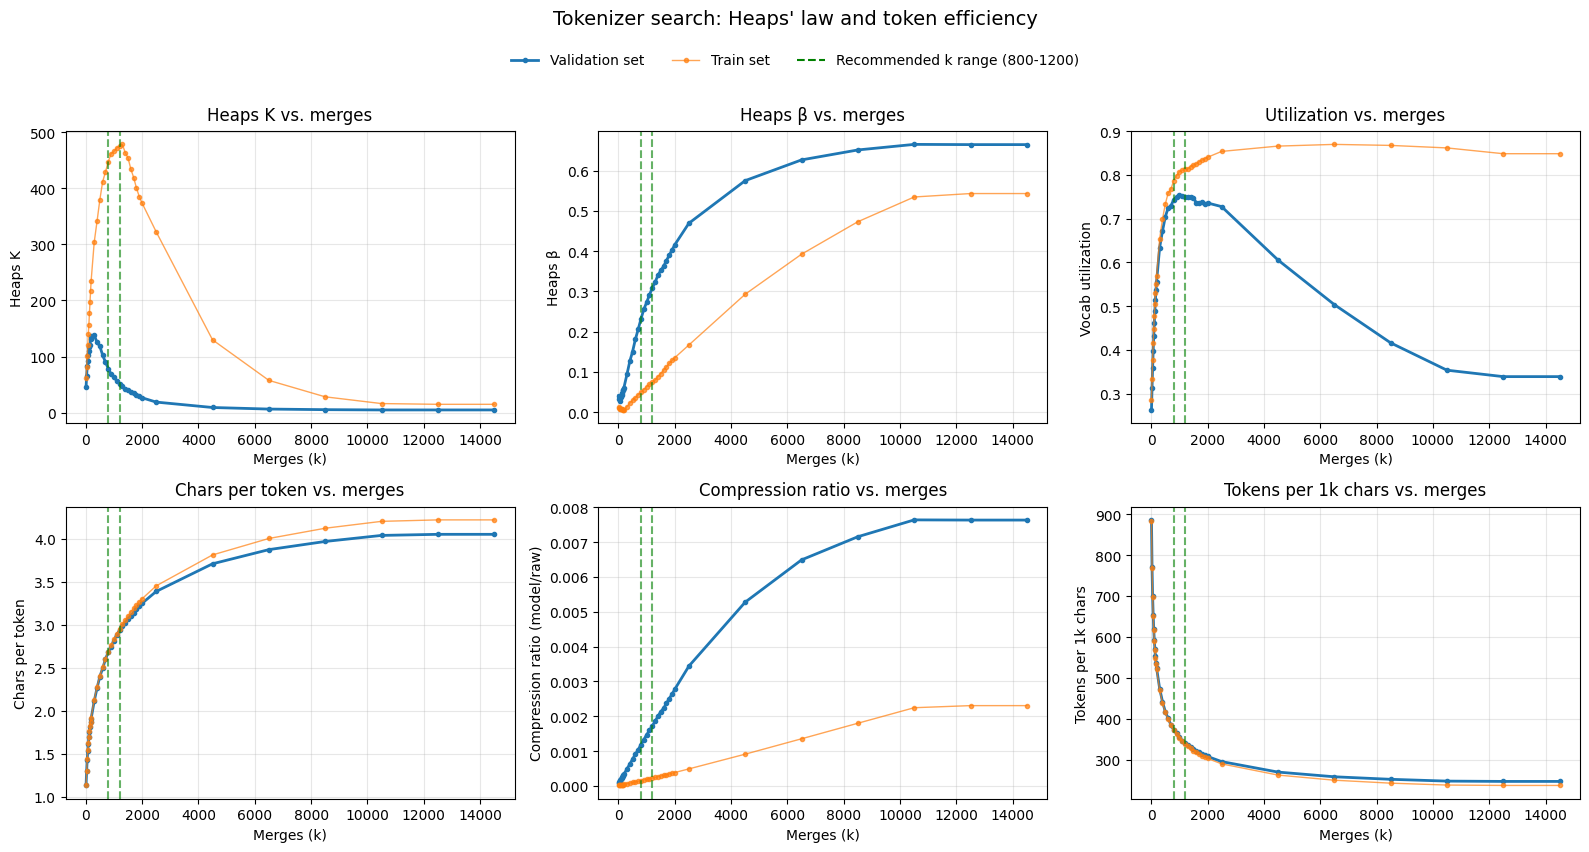

(<Figure size 1600x800 with 6 Axes>,
 array([[<Axes: title={'center': 'Heaps K vs. merges'}, xlabel='Merges (k)', ylabel='Heaps K'>,
         <Axes: title={'center': 'Heaps β vs. merges'}, xlabel='Merges (k)', ylabel='Heaps β'>,
         <Axes: title={'center': 'Utilization vs. merges'}, xlabel='Merges (k)', ylabel='Vocab utilization'>],
        [<Axes: title={'center': 'Chars per token vs. merges'}, xlabel='Merges (k)', ylabel='Chars per token'>,
         <Axes: title={'center': 'Compression ratio vs. merges'}, xlabel='Merges (k)', ylabel='Compression ratio (model/raw)'>,
         <Axes: title={'center': 'Tokens per 1k chars vs. merges'}, xlabel='Merges (k)', ylabel='Tokens per 1k chars'>]],
       dtype=object))

In [18]:
recommended_k_range = [800, 1200]
plot_heaps_and_metrics(
    df_tokenizer_search,
    recommended_k_range=recommended_k_range,
    suptitle="Tokenizer search: Heaps' law and token efficiency",
    save_path=os.path.join(TOKENIZER_RESULTS_DIR, "tokenizer_search_results.png")
)

In [ ]:
# exponentiated gradient for fitting λ
def set_py_seed(seed: int = 1337):
    random.seed(seed)
    np.random.seed(seed)

def train_and_encode(tokenizer_trainer,
                     train_text_path: str,
                     val_text_path: str,
                     merges: int,
                     min_frequency: int,
                     lowercase: bool,
                     add_prefix_space: bool,
                     name_prefix: str = "bpe",
                     special_tokens: dict = SPECIAL_TOKENS):
    
    with open(train_text_path, "r", encoding="utf-8") as f:
        train_text = f.read().strip()

    with open(val_text_path, "r", encoding="utf-8") as f:
        val_text = f.read().strip()

    tok = tokenizer_trainer(
        files=[train_text_path],
        merges=merges,
        min_frequency=min_frequency,
        lowercase=lowercase,
        add_prefix_space=add_prefix_space,
        name=f"{name_prefix}_{merges}"
    )
    encode = partial(tok.encode, add_special_tokens=False)
    train_ids = encode(train_text).ids
    val_ids   = encode(val_text).ids
    pad_id = tok.token_to_id(special_tokens['pad']) if special_tokens.get('pad', None) is not None else BOS_TOKEN_ID

    chars_per_token_val = len(val_text) / max(1, len(val_ids))
    tokens_per_1k_chars_val = len(val_ids) / max(1, len(val_text) / 1000.0)
    info = {
        "tokenizer": tok,
        "train_ids": train_ids,
        "val_ids": val_ids,
        "pad_id": pad_id,
        "vocab_size": tok.get_vocab_size(),
        "chars_per_token_val": chars_per_token_val,
        "tokens_per_1k_chars_val": tokens_per_1k_chars_val,
    }
    return info

def _component_probs_matrix(model, ids, n: int, k_smoothing: float = 1.0, eps: float = 1e-12):
    """
    Build a matrix P of shape (T, n) with per-order component probabilities p_m(t)
    for t = n-1 .. len(ids)-1. Returns (P, start_index).
    """
    ids = list(ids)
    T = len(ids) - (n - 1)
    if T <= 0:
        return np.zeros((0, n), dtype=np.float64), (n - 1)

    P = np.zeros((T, n), dtype=np.float64)
    for t in range(n - 1, len(ids)):
        ctx = ids[t - n + 1 : t]
        tok = ids[t]
        # m = 1..n. For each m, query = last (m-1) of ctx plus tok
        for m in range(1, n + 1):
            prefix = ctx[-(m - 1):] if m > 1 else []
            query = tuple(prefix + [tok])
            p = model._n_gram_prob(query, m, k_smoothing=k_smoothing)
            P[t - (n - 1), m - 1] = max(p, eps)  # clamp to eps for stability
    return P, (n - 1)

def _loss_and_grad_bpt(lam: np.ndarray, P: np.ndarray, eps: float = 1e-12):
    """
    Compute (bits-per-token loss, gradient wrt lam) for mixture:
        L = - (1/T) sum_t log( sum_m lam_m * P[t,m] )
    grad_k = - (1/T) sum_t ( P[t,k] / sum_j lam_j * P[t,j] )
    Returns (bpt, grad) where bpt = nats/log(2).
    """
    mix = P @ lam  # shape (T,)
    mix = np.clip(mix, eps, None)
    nats = -np.mean(np.log(mix))
    bpt = nats / math.log(2.0)
    # gradient in nats
    # avg over t of ( - P[:,k] / mix )
    grad_nats = - (P / mix[:, None]).mean(axis=0)  # shape (n,)
    grad_bpt = grad_nats / math.log(2.0)
    return bpt, grad_bpt

def fit_lambdas_exponentiated_gradient(
    model,
    val_ids,
    n: int,
    *,
    k_smoothing: float = 1.0,
    max_iters: int = 500,
    eta: float = 0.5,             # initial step size in mirror space
    tol_rel: float = 1e-6,
    backtrack: bool = True,
    backtrack_factor: float = 0.5,
    min_lambda: float = 1e-12,
    verbose: bool = False,
):
    """
    Solve for lambda via Exponentiated Gradient to minimize BPT on val_ids.
    Returns lam (shape (n,)) and final bpt.
    """
    # precompute component probabilities on validation stream
    P, _ = _component_probs_matrix(model, val_ids, n=n, k_smoothing=k_smoothing)
    if P.shape[0] == 0:
        # degenerate stream → uniform weights
        return np.ones(n) / n, float("inf")

    # initialize with uniform
    lam = np.ones(n, dtype=np.float64) / n
    bpt, grad = _loss_and_grad_bpt(lam, P)

    for it in range(max_iters):
        old_bpt = bpt
        # mirror (EG) step: lam_new ∝ lam * exp(-eta * grad)
        step = eta
        while True:
            lam_prop = lam * np.exp(-step * grad)
            lam_prop = np.clip(lam_prop, min_lambda, None)
            lam_prop /= lam_prop.sum()

            bpt_prop, grad_prop = _loss_and_grad_bpt(lam_prop, P)

            # Armijo-like acceptance
            if not backtrack or (bpt_prop <= bpt - 1e-12):
                lam, bpt, grad = lam_prop, bpt_prop, grad_prop
                break
            step *= backtrack_factor
            if step < 1e-8:
                # give up shrinking; accept anyway to avoid stall
                lam, bpt, grad = lam_prop, bpt_prop, grad_prop
                break

        # convergence check (relative change)
        if abs(old_bpt - bpt) / max(1e-12, bpt) < tol_rel:
            if verbose:
                print(f"[EG] converged in {it+1} iters. bpt={bpt:.6f}")
            break

    return lam, bpt

def fit_ngram_hparams(
    *,
    train_text_path: str,
    val_text_path: str,
    n_grid=(2, 3, 4, 5),
    merges_grid=(500, 1000, 2000),
    tokenizer_trainer=None,
    min_frequency: int = 2,
    lowercase: bool = False,
    add_prefix_space: bool = True,
    log_every: int = 1,
    seed: int = 1337,
    verbose: bool = True,
    csv_log_path: str | None = None,
    special_tokens: dict | None = SPECIAL_TOKENS,
):
    assert tokenizer_trainer is not None, "pass tokenizer_trainer=train_bytelevel_bpe (or compatible)."
    set_py_seed(seed)

    rows = []
    total = len(merges_grid) * len(n_grid)
    pbar = tqdm(total=total, desc="Hyperparam search")

    for merges in merges_grid:
        # initialize tokenizer and encode train/val
        tok_info = train_and_encode(
            tokenizer_trainer, train_text_path, val_text_path,
            merges=merges, min_frequency=min_frequency,
            lowercase=lowercase, add_prefix_space=add_prefix_space,
            name_prefix="bpe",
            special_tokens=special_tokens
        )
        train_ids = tok_info["train_ids"]
        val_ids   = tok_info["val_ids"]
        pad_id    = tok_info["pad_id"]
        vocab_sz  = tok_info["vocab_size"]
        chars_per_token_val       = tok_info["chars_per_token_val"]
        tokens_per_1k_chars_val   = tok_info["tokens_per_1k_chars_val"]

        for n in n_grid:
            # fit n-gram counts on train ids
            model = NGramEngine(n)
            model.fit(train_ids, pad_token=pad_id)

            # === Rigorous lambda optimization on validation set ===
            best_lam, _ = fit_lambdas_exponentiated_gradient(
                model, val_ids, n=n,
                k_smoothing=1.0,
                max_iters=500,
                eta=0.5,
                tol_rel=1e-7,
                backtrack=True,
                backtrack_factor=0.5,
                min_lambda=1e-12,
                verbose=False
            )

            # get metrics on val and train (using the final λ)
            model.lambdas = best_lam
            val_metrics   = model.fit_metrics(val_ids,   n=n, interpolate=True)
            train_metrics = model.fit_metrics(train_ids, n=n, interpolate=True)

            row = {
                "merges": merges,
                "n": n,
                "vocab_size": vocab_sz,
                "chars_per_token_val":       chars_per_token_val,
                "tokens_per_1k_chars_val":   tokens_per_1k_chars_val,
                "val_bpt":   val_metrics["bpt"],
                "val_ppl":   val_metrics["ppl"],
                "train_bpt": train_metrics["bpt"],
                "train_ppl": train_metrics["ppl"],
                "best_lambdas": best_lam.tolist(),
                "effective_tokens_val":   val_metrics["effective_tokens"],
                "effective_tokens_train": train_metrics["effective_tokens"],
            }
            rows.append(row)

            if verbose and (len(rows) % max(1, log_every) == 0):
                print(f"[k={merges:>5}, n={n}] "
                      f"val bpt={row['val_bpt']:.3f}, ppl={row['val_ppl']:.1f}, "
                      f"train bpt={row['train_bpt']:.3f} | λ={np.array2string(best_lam, precision=4)}")

            pbar.update(1)

    pbar.close()
    df = pd.DataFrame(rows).sort_values(["merges", "n"]).reset_index(drop=True)

    if csv_log_path:
        os.makedirs(os.path.dirname(csv_log_path), exist_ok=True)
        df.to_csv(csv_log_path, index=False)

    return df


In [19]:
df_ngram_fit_results = fit_ngram_hparams(
    train_text_path=train_file,
    val_text_path=val_file,
    n_grid=np.arange(2,10),
    merges_grid=[10, 50, 100, 200, 500, 800, 1000, 1200, 2000, 5000, 10000],
    tokenizer_trainer=train_bytelevel_bpe,   
    min_frequency=2,
    lowercase=False,
    add_prefix_space=True,
    csv_log_path=os.path.join(NGRAM_RESULTS_DIR, "ngram_hparams_fit.csv"),
    verbose=True
)

Hyperparam search:   0%|          | 0/88 [00:00<?, ?it/s]




Saved tokenizer to bpe_tok/bpe_10.json | vocab=270 (requested merges=10)


Hyperparam search:   1%|          | 1/88 [00:06<09:22,  6.46s/it]

[k=   10, n=2] val bpt=3.895, ppl=14.9, train bpt=3.885 | λ=[3.8432e-06 1.0000e+00]


Hyperparam search:   2%|▏         | 2/88 [00:12<09:11,  6.42s/it]

[k=   10, n=3] val bpt=3.107, ppl=8.6, train bpt=3.075 | λ=[4.8610e-13 3.9783e-05 9.9996e-01]


Hyperparam search:   3%|▎         | 3/88 [00:20<09:57,  7.03s/it]

[k=   10, n=4] val bpt=2.982, ppl=7.9, train bpt=2.915 | λ=[4.8610e-13 9.8327e-06 4.4196e-01 5.5803e-01]


Hyperparam search:   5%|▍         | 4/88 [00:29<11:06,  7.93s/it]

[k=   10, n=5] val bpt=2.982, ppl=7.9, train bpt=2.915 | λ=[4.8610e-13 6.4887e-07 4.4218e-01 5.5781e-01 1.4432e-05]


Hyperparam search:   6%|▌         | 5/88 [00:41<12:37,  9.13s/it]

[k=   10, n=6] val bpt=2.982, ppl=7.9, train bpt=2.915 | λ=[4.8610e-13 6.9896e-07 4.4221e-01 5.5777e-01 1.4175e-05 3.5897e-12]


Hyperparam search:   7%|▋         | 6/88 [00:53<13:47, 10.10s/it]

[k=   10, n=7] val bpt=2.982, ppl=7.9, train bpt=2.915 | λ=[4.8610e-13 6.7129e-07 4.4221e-01 5.5778e-01 1.3418e-05 3.1581e-12
 4.8610e-13]


Hyperparam search:   8%|▊         | 7/88 [01:06<15:05, 11.17s/it]

[k=   10, n=8] val bpt=2.982, ppl=7.9, train bpt=2.915 | λ=[4.8610e-13 7.2992e-07 4.4225e-01 5.5774e-01 1.4210e-05 3.6770e-12
 4.8610e-13 4.8610e-13]


Hyperparam search:   9%|▉         | 8/88 [01:21<16:29, 12.37s/it]

[k=   10, n=9] val bpt=2.982, ppl=7.9, train bpt=2.915 | λ=[4.8610e-13 7.0741e-07 4.4224e-01 5.5774e-01 1.3790e-05 3.4166e-12
 4.8610e-13 4.8610e-13 4.8610e-13]



Saved tokenizer to bpe_tok/bpe_50.json | vocab=310 (requested merges=50)


Hyperparam search:  10%|█         | 9/88 [01:26<13:22, 10.16s/it]

[k=   50, n=2] val bpt=4.452, ppl=21.9, train bpt=4.432 | λ=[1.8168e-06 1.0000e+00]


Hyperparam search:  11%|█▏        | 10/88 [01:31<11:13,  8.63s/it]

[k=   50, n=3] val bpt=3.799, ppl=13.9, train bpt=3.716 | λ=[4.8610e-13 5.2060e-02 9.4794e-01]


Hyperparam search:  12%|█▎        | 11/88 [01:38<10:15,  8.00s/it]

[k=   50, n=4] val bpt=3.799, ppl=13.9, train bpt=3.714 | λ=[4.8610e-13 5.0085e-02 9.3975e-01 1.0165e-02]


Hyperparam search:  14%|█▎        | 12/88 [01:46<10:00,  7.90s/it]

[k=   50, n=5] val bpt=3.799, ppl=13.9, train bpt=3.714 | λ=[4.8610e-13 5.0091e-02 9.3976e-01 1.0151e-02 4.8610e-13]


Hyperparam search:  15%|█▍        | 13/88 [01:55<10:14,  8.20s/it]

[k=   50, n=6] val bpt=3.799, ppl=13.9, train bpt=3.714 | λ=[4.8610e-13 5.0097e-02 9.3978e-01 1.0119e-02 4.8610e-13 4.8610e-13]


Hyperparam search:  16%|█▌        | 14/88 [02:05<10:56,  8.87s/it]

[k=   50, n=7] val bpt=3.799, ppl=13.9, train bpt=3.714 | λ=[4.8610e-13 5.0106e-02 9.3979e-01 1.0100e-02 4.8610e-13 4.8610e-13
 4.8610e-13]


Hyperparam search:  17%|█▋        | 15/88 [02:17<11:56,  9.82s/it]

[k=   50, n=8] val bpt=3.799, ppl=13.9, train bpt=3.714 | λ=[4.8610e-13 5.0108e-02 9.3977e-01 1.0124e-02 4.8610e-13 4.8610e-13
 4.8610e-13 4.8610e-13]


Hyperparam search:  18%|█▊        | 16/88 [02:30<12:46, 10.64s/it]

[k=   50, n=9] val bpt=3.799, ppl=13.9, train bpt=3.714 | λ=[4.8610e-13 5.0106e-02 9.3979e-01 1.0109e-02 4.8610e-13 4.8610e-13
 4.8610e-13 4.8610e-13 4.8610e-13]



Saved tokenizer to bpe_tok/bpe_100.json | vocab=360 (requested merges=100)


Hyperparam search:  19%|█▉        | 17/88 [02:34<10:30,  8.87s/it]

[k=  100, n=2] val bpt=4.833, ppl=28.5, train bpt=4.797 | λ=[1.6587e-06 1.0000e+00]


Hyperparam search:  20%|██        | 18/88 [02:39<08:48,  7.54s/it]

[k=  100, n=3] val bpt=4.424, ppl=21.5, train bpt=4.306 | λ=[1.4272e-07 2.9127e-01 7.0873e-01]


Hyperparam search:  22%|██▏       | 19/88 [02:44<07:57,  6.92s/it]

[k=  100, n=4] val bpt=4.424, ppl=21.5, train bpt=4.306 | λ=[4.8610e-13 2.9027e-01 7.0972e-01 8.7008e-06]


Hyperparam search:  23%|██▎       | 20/88 [02:51<07:39,  6.76s/it]

[k=  100, n=5] val bpt=4.424, ppl=21.5, train bpt=4.306 | λ=[4.8610e-13 2.9029e-01 7.0970e-01 8.5955e-06 1.5928e-10]


Hyperparam search:  24%|██▍       | 21/88 [02:58<07:44,  6.94s/it]

[k=  100, n=6] val bpt=4.424, ppl=21.5, train bpt=4.306 | λ=[4.8610e-13 2.9030e-01 7.0969e-01 7.8355e-06 1.3404e-10 5.8650e-13]


Hyperparam search:  25%|██▌       | 22/88 [03:06<08:04,  7.34s/it]

[k=  100, n=7] val bpt=4.424, ppl=21.5, train bpt=4.306 | λ=[4.8610e-13 2.9032e-01 7.0967e-01 8.5199e-06 1.6121e-10 7.4320e-13
 4.8610e-13]


Hyperparam search:  26%|██▌       | 23/88 [03:16<08:35,  7.93s/it]

[k=  100, n=8] val bpt=4.424, ppl=21.5, train bpt=4.306 | λ=[4.8610e-13 2.9030e-01 7.0969e-01 8.0442e-06 1.4472e-10 6.5120e-13
 4.8610e-13 4.8610e-13]


Hyperparam search:  27%|██▋       | 24/88 [03:26<09:13,  8.65s/it]

[k=  100, n=9] val bpt=4.424, ppl=21.5, train bpt=4.306 | λ=[4.8610e-13 2.9027e-01 7.0972e-01 7.6573e-06 1.3189e-10 5.8120e-13
 4.8610e-13 4.8610e-13 4.8610e-13]



Saved tokenizer to bpe_tok/bpe_200.json | vocab=460 (requested merges=200)


Hyperparam search:  28%|██▊       | 25/88 [03:30<07:41,  7.32s/it]

[k=  200, n=2] val bpt=5.262, ppl=38.4, train bpt=5.209 | λ=[1.2957e-06 1.0000e+00]


Hyperparam search:  30%|██▉       | 26/88 [03:34<06:29,  6.28s/it]

[k=  200, n=3] val bpt=5.126, ppl=34.9, train bpt=5.015 | λ=[6.6749e-07 6.1824e-01 3.8175e-01]


Hyperparam search:  31%|███       | 27/88 [03:39<05:56,  5.84s/it]

[k=  200, n=4] val bpt=5.126, ppl=34.9, train bpt=5.015 | λ=[3.2528e-10 6.1879e-01 3.8120e-01 4.0108e-06]


Hyperparam search:  32%|███▏      | 28/88 [03:44<05:46,  5.78s/it]

[k=  200, n=5] val bpt=5.126, ppl=34.9, train bpt=5.015 | λ=[2.6597e-10 6.1880e-01 3.8120e-01 3.3645e-06 7.4428e-09]


Hyperparam search:  33%|███▎      | 29/88 [03:51<05:54,  6.01s/it]

[k=  200, n=6] val bpt=5.126, ppl=34.9, train bpt=5.015 | λ=[3.4640e-10 6.1882e-01 3.8117e-01 3.7646e-06 8.9100e-09 6.6287e-10]


Hyperparam search:  34%|███▍      | 30/88 [03:58<06:09,  6.37s/it]

[k=  200, n=7] val bpt=5.126, ppl=34.9, train bpt=5.015 | λ=[2.9889e-10 6.1883e-01 3.8116e-01 3.4210e-06 7.7185e-09 5.6255e-10
 1.5541e-10]


Hyperparam search:  35%|███▌      | 31/88 [04:06<06:30,  6.86s/it]

[k=  200, n=8] val bpt=5.126, ppl=34.9, train bpt=5.015 | λ=[4.0523e-10 6.1882e-01 3.8117e-01 3.9810e-06 9.8083e-09 7.4338e-10
 2.0941e-10 1.0906e-10]


Hyperparam search:  36%|███▋      | 32/88 [04:15<06:58,  7.47s/it]

[k=  200, n=9] val bpt=5.126, ppl=34.9, train bpt=5.015 | λ=[3.6076e-10 6.1879e-01 3.8120e-01 3.7087e-06 8.8228e-09 6.5879e-10
 1.8422e-10 9.5580e-11 6.7056e-11]



Saved tokenizer to bpe_tok/bpe_500.json | vocab=760 (requested merges=500)


Hyperparam search:  38%|███▊      | 33/88 [04:19<05:47,  6.31s/it]

[k=  500, n=2] val bpt=6.156, ppl=71.3, train bpt=6.019 | λ=[2.4297e-06 1.0000e+00]


Hyperparam search:  39%|███▊      | 34/88 [04:22<04:50,  5.38s/it]

[k=  500, n=3] val bpt=6.156, ppl=71.3, train bpt=6.019 | λ=[4.8610e-13 9.9997e-01 2.6550e-05]


Hyperparam search:  40%|███▉      | 35/88 [04:26<04:20,  4.91s/it]

[k=  500, n=4] val bpt=6.156, ppl=71.3, train bpt=6.019 | λ=[5.9579e-13 9.9997e-01 2.7806e-05 2.3468e-12]


Hyperparam search:  41%|████      | 36/88 [04:30<04:08,  4.78s/it]

[k=  500, n=5] val bpt=6.156, ppl=71.3, train bpt=6.019 | λ=[6.9440e-13 9.9997e-01 2.8285e-05 2.5917e-12 4.8610e-13]


Hyperparam search:  42%|████▏     | 37/88 [04:35<04:09,  4.89s/it]

[k=  500, n=6] val bpt=6.156, ppl=71.3, train bpt=6.019 | λ=[6.0411e-13 9.9997e-01 2.6597e-05 2.2308e-12 4.8610e-13 4.8610e-13]


Hyperparam search:  43%|████▎     | 38/88 [04:41<04:17,  5.16s/it]

[k=  500, n=7] val bpt=6.156, ppl=71.3, train bpt=6.019 | λ=[7.3470e-13 9.9997e-01 2.7903e-05 2.6513e-12 4.8610e-13 4.8610e-13
 4.8610e-13]


Hyperparam search:  44%|████▍     | 39/88 [04:48<04:32,  5.55s/it]

[k=  500, n=8] val bpt=6.156, ppl=71.3, train bpt=6.019 | λ=[6.5852e-13 9.9997e-01 2.6699e-05 2.3816e-12 4.8610e-13 4.8610e-13
 4.8610e-13 4.8610e-13]


Hyperparam search:  45%|████▌     | 40/88 [04:55<04:49,  6.03s/it]

[k=  500, n=9] val bpt=6.156, ppl=71.3, train bpt=6.019 | λ=[8.1961e-13 9.9997e-01 2.8369e-05 2.9123e-12 4.8610e-13 4.8610e-13
 4.8610e-13 4.8610e-13 4.8610e-13]



Saved tokenizer to bpe_tok/bpe_800.json | vocab=1060 (requested merges=800)


Hyperparam search:  47%|████▋     | 41/88 [04:58<04:05,  5.22s/it]

[k=  800, n=2] val bpt=6.846, ppl=115.1, train bpt=6.644 | λ=[8.2458e-06 9.9999e-01]


Hyperparam search:  48%|████▊     | 42/88 [05:01<03:27,  4.52s/it]

[k=  800, n=3] val bpt=6.846, ppl=115.1, train bpt=6.644 | λ=[5.7888e-06 9.9999e-01 8.2738e-07]


Hyperparam search:  49%|████▉     | 43/88 [05:04<03:08,  4.19s/it]

[k=  800, n=4] val bpt=6.846, ppl=115.1, train bpt=6.644 | λ=[6.1558e-06 9.9999e-01 8.2625e-07 8.0634e-10]


Hyperparam search:  50%|█████     | 44/88 [05:08<03:01,  4.13s/it]

[k=  800, n=5] val bpt=6.846, ppl=115.1, train bpt=6.644 | λ=[6.6979e-06 9.9999e-01 8.9602e-07 9.2954e-10 9.1857e-11]


Hyperparam search:  51%|█████     | 45/88 [05:13<03:03,  4.26s/it]

[k=  800, n=6] val bpt=6.846, ppl=115.1, train bpt=6.644 | λ=[6.1171e-06 9.9999e-01 7.9031e-07 7.7639e-10 7.5373e-11 3.4461e-11]


Hyperparam search:  52%|█████▏    | 46/88 [05:18<03:10,  4.53s/it]

[k=  800, n=7] val bpt=6.846, ppl=115.1, train bpt=6.644 | λ=[6.8346e-06 9.9999e-01 9.0294e-07 9.6581e-10 9.6619e-11 4.4631e-11
 3.3468e-11]


Hyperparam search:  53%|█████▎    | 47/88 [05:24<03:20,  4.89s/it]

[k=  800, n=8] val bpt=6.846, ppl=115.1, train bpt=6.644 | λ=[6.3538e-06 9.9999e-01 8.2288e-07 8.4619e-10 8.3580e-11 3.8447e-11
 2.8787e-11 2.5522e-11]


Hyperparam search:  55%|█████▍    | 48/88 [05:30<03:32,  5.30s/it]

[k=  800, n=9] val bpt=6.846, ppl=115.1, train bpt=6.644 | λ=[5.9482e-06 9.9999e-01 7.5738e-07 7.5217e-10 7.3469e-11 3.3672e-11
 2.5179e-11 2.2311e-11 2.1033e-11]



Saved tokenizer to bpe_tok/bpe_1000.json | vocab=1260 (requested merges=1000)


Hyperparam search:  56%|█████▌    | 49/88 [05:33<03:02,  4.69s/it]

[k= 1000, n=2] val bpt=7.207, ppl=147.7, train bpt=6.990 | λ=[4.7501e-05 9.9995e-01]


Hyperparam search:  57%|█████▋    | 50/88 [05:36<02:36,  4.11s/it]

[k= 1000, n=3] val bpt=7.207, ppl=147.7, train bpt=6.990 | λ=[4.8608e-05 9.9995e-01 2.1926e-11]


Hyperparam search:  58%|█████▊    | 51/88 [05:39<02:23,  3.88s/it]

[k= 1000, n=4] val bpt=7.207, ppl=147.7, train bpt=6.990 | λ=[4.9947e-05 9.9995e-01 2.2463e-11 4.8610e-13]


Hyperparam search:  59%|█████▉    | 52/88 [05:43<02:19,  3.88s/it]

[k= 1000, n=5] val bpt=7.207, ppl=147.7, train bpt=6.990 | λ=[4.7743e-05 9.9995e-01 1.8859e-11 4.8610e-13 4.8610e-13]


Hyperparam search:  60%|██████    | 53/88 [05:48<02:20,  4.03s/it]

[k= 1000, n=6] val bpt=7.207, ppl=147.7, train bpt=6.990 | λ=[4.9859e-05 9.9995e-01 2.1665e-11 4.8610e-13 4.8610e-13 4.8610e-13]


Hyperparam search:  61%|██████▏   | 54/88 [05:53<02:26,  4.30s/it]

[k= 1000, n=7] val bpt=7.207, ppl=147.7, train bpt=6.990 | λ=[4.8186e-05 9.9995e-01 1.9237e-11 4.8610e-13 4.8610e-13 4.8610e-13
 4.8610e-13]


Hyperparam search:  62%|██████▎   | 55/88 [05:58<02:33,  4.66s/it]

[k= 1000, n=8] val bpt=7.207, ppl=147.7, train bpt=6.990 | λ=[5.0572e-05 9.9995e-01 2.2924e-11 4.8610e-13 4.8610e-13 4.8610e-13
 4.8610e-13 4.8610e-13]


Hyperparam search:  64%|██████▎   | 56/88 [06:04<02:41,  5.06s/it]

[k= 1000, n=9] val bpt=7.207, ppl=147.7, train bpt=6.990 | λ=[4.9125e-05 9.9995e-01 2.0931e-11 4.8610e-13 4.8610e-13 4.8610e-13
 4.8610e-13 4.8610e-13 4.8610e-13]



Saved tokenizer to bpe_tok/bpe_1200.json | vocab=1460 (requested merges=1200)


Hyperparam search:  65%|██████▍   | 57/88 [06:07<02:19,  4.50s/it]

[k= 1200, n=2] val bpt=7.515, ppl=183.0, train bpt=7.284 | λ=[0.0175 0.9825]


Hyperparam search:  66%|██████▌   | 58/88 [06:10<01:58,  3.94s/it]

[k= 1200, n=3] val bpt=7.515, ppl=183.0, train bpt=7.284 | λ=[1.7488e-02 9.8251e-01 3.6994e-10]


Hyperparam search:  67%|██████▋   | 59/88 [06:13<01:47,  3.71s/it]

[k= 1200, n=4] val bpt=7.515, ppl=183.0, train bpt=7.284 | λ=[1.7439e-02 9.8256e-01 2.8531e-10 4.8610e-13]


Hyperparam search:  68%|██████▊   | 60/88 [06:17<01:43,  3.69s/it]

[k= 1200, n=5] val bpt=7.516, ppl=183.0, train bpt=7.284 | λ=[1.7479e-02 9.8252e-01 3.1967e-10 4.8610e-13 4.8610e-13]


Hyperparam search:  69%|██████▉   | 61/88 [06:21<01:43,  3.84s/it]

[k= 1200, n=6] val bpt=7.516, ppl=183.0, train bpt=7.284 | λ=[1.7449e-02 9.8255e-01 2.7601e-10 4.8610e-13 4.8610e-13 4.8610e-13]


Hyperparam search:  70%|███████   | 62/88 [06:26<01:46,  4.09s/it]

[k= 1200, n=7] val bpt=7.516, ppl=183.0, train bpt=7.284 | λ=[1.7499e-02 9.8250e-01 3.2783e-10 4.8610e-13 4.8610e-13 4.8610e-13
 4.8610e-13]


Hyperparam search:  72%|███████▏  | 63/88 [06:31<01:50,  4.43s/it]

[k= 1200, n=8] val bpt=7.516, ppl=183.0, train bpt=7.284 | λ=[1.7459e-02 9.8254e-01 2.9427e-10 4.8610e-13 4.8610e-13 4.8610e-13
 4.8610e-13 4.8610e-13]


Hyperparam search:  73%|███████▎  | 64/88 [06:37<01:57,  4.88s/it]

[k= 1200, n=9] val bpt=7.516, ppl=183.0, train bpt=7.284 | λ=[1.7511e-02 9.8249e-01 3.5994e-10 4.8610e-13 4.8610e-13 4.8610e-13
 4.8610e-13 4.8610e-13 4.8610e-13]



Saved tokenizer to bpe_tok/bpe_2000.json | vocab=2260 (requested merges=2000)


Hyperparam search:  74%|███████▍  | 65/88 [06:40<01:39,  4.32s/it]

[k= 2000, n=2] val bpt=8.326, ppl=320.9, train bpt=8.123 | λ=[0.2242 0.7758]


Hyperparam search:  75%|███████▌  | 66/88 [06:42<01:22,  3.76s/it]

[k= 2000, n=3] val bpt=8.326, ppl=321.0, train bpt=8.123 | λ=[2.2330e-01 7.7670e-01 3.1677e-06]


Hyperparam search:  76%|███████▌  | 67/88 [06:45<01:13,  3.49s/it]

[k= 2000, n=4] val bpt=8.326, ppl=321.0, train bpt=8.123 | λ=[2.2329e-01 7.7671e-01 2.4007e-06 1.6003e-07]


Hyperparam search:  77%|███████▋  | 68/88 [06:48<01:08,  3.44s/it]

[k= 2000, n=5] val bpt=8.326, ppl=320.9, train bpt=8.123 | λ=[2.2329e-01 7.7671e-01 1.9566e-06 1.2547e-07 6.6585e-08]


Hyperparam search:  78%|███████▊  | 69/88 [06:52<01:07,  3.53s/it]

[k= 2000, n=6] val bpt=8.326, ppl=320.9, train bpt=8.123 | λ=[2.2332e-01 7.7668e-01 2.3143e-06 1.5494e-07 8.3115e-08 7.0547e-08]


Hyperparam search:  80%|███████▉  | 70/88 [06:56<01:06,  3.72s/it]

[k= 2000, n=7] val bpt=8.326, ppl=320.9, train bpt=8.123 | λ=[2.2328e-01 7.7672e-01 2.0157e-06 1.3151e-07 7.0145e-08 5.9451e-08
 5.5723e-08]


Hyperparam search:  81%|████████  | 71/88 [07:01<01:07,  3.99s/it]

[k= 2000, n=8] val bpt=8.326, ppl=321.0, train bpt=8.123 | λ=[2.2328e-01 7.7672e-01 1.7879e-06 1.1408e-07 6.0553e-08 5.1258e-08
 4.8022e-08 4.7176e-08]


Hyperparam search:  82%|████████▏ | 72/88 [07:06<01:09,  4.32s/it]

[k= 2000, n=9] val bpt=8.326, ppl=321.0, train bpt=8.123 | λ=[2.2331e-01 7.7669e-01 2.2378e-06 1.5086e-07 8.1151e-08 6.8942e-08
 6.4685e-08 6.3571e-08 6.3028e-08]



Saved tokenizer to bpe_tok/bpe_5000.json | vocab=5260 (requested merges=5000)


Hyperparam search:  83%|████████▎ | 73/88 [07:09<00:57,  3.83s/it]

[k= 5000, n=2] val bpt=9.251, ppl=609.1, train bpt=9.070 | λ=[0.5527 0.4473]


Hyperparam search:  84%|████████▍ | 74/88 [07:11<00:45,  3.27s/it]

[k= 5000, n=3] val bpt=9.251, ppl=609.2, train bpt=9.070 | λ=[5.5358e-01 4.4642e-01 3.7569e-06]


Hyperparam search:  85%|████████▌ | 75/88 [07:13<00:39,  3.00s/it]

[k= 5000, n=4] val bpt=9.251, ppl=609.2, train bpt=9.070 | λ=[5.5356e-01 4.4644e-01 2.8157e-06 4.7988e-07]


Hyperparam search:  86%|████████▋ | 76/88 [07:16<00:35,  2.93s/it]

[k= 5000, n=5] val bpt=9.251, ppl=609.1, train bpt=9.070 | λ=[5.5357e-01 4.4643e-01 2.2659e-06 3.7531e-07 2.7401e-07]


Hyperparam search:  88%|████████▊ | 77/88 [07:19<00:32,  3.00s/it]

[k= 5000, n=6] val bpt=9.251, ppl=609.2, train bpt=9.070 | λ=[5.5353e-01 4.4647e-01 1.9001e-06 3.0757e-07 2.2372e-07 2.0817e-07]


Hyperparam search:  89%|████████▊ | 78/88 [07:22<00:31,  3.14s/it]

[k= 5000, n=7] val bpt=9.251, ppl=609.2, train bpt=9.070 | λ=[5.5352e-01 4.4648e-01 1.6364e-06 2.5976e-07 1.8835e-07 1.7513e-07
 1.6933e-07]


Hyperparam search:  90%|████████▉ | 79/88 [07:26<00:30,  3.35s/it]

[k= 5000, n=8] val bpt=9.251, ppl=609.1, train bpt=9.070 | λ=[5.5355e-01 4.4644e-01 1.9762e-06 3.2402e-07 2.3640e-07 2.2011e-07
 2.1297e-07 2.1090e-07]


Hyperparam search:  91%|█████████ | 80/88 [07:31<00:28,  3.62s/it]

[k= 5000, n=9] val bpt=9.250, ppl=609.1, train bpt=9.070 | λ=[5.5357e-01 4.4643e-01 1.7558e-06 2.8354e-07 2.0637e-07 1.9205e-07
 1.8577e-07 1.8395e-07 1.8333e-07]



Saved tokenizer to bpe_tok/bpe_10000.json | vocab=10260 (requested merges=10000)


Hyperparam search:  92%|█████████▏| 81/88 [07:33<00:23,  3.32s/it]

[k=10000, n=2] val bpt=9.580, ppl=765.5, train bpt=9.373 | λ=[0.718 0.282]


Hyperparam search:  93%|█████████▎| 82/88 [07:35<00:17,  2.88s/it]

[k=10000, n=3] val bpt=9.580, ppl=765.5, train bpt=9.373 | λ=[7.1886e-01 2.8114e-01 3.8594e-06]


Hyperparam search:  94%|█████████▍| 83/88 [07:37<00:13,  2.68s/it]

[k=10000, n=4] val bpt=9.580, ppl=765.5, train bpt=9.373 | λ=[7.1884e-01 2.8116e-01 2.8932e-06 7.3137e-07]


Hyperparam search:  95%|█████████▌| 84/88 [07:40<00:10,  2.64s/it]

[k=10000, n=5] val bpt=9.580, ppl=765.4, train bpt=9.373 | λ=[7.1884e-01 2.8116e-01 2.3222e-06 5.7215e-07 4.6814e-07]


Hyperparam search:  97%|█████████▋| 85/88 [07:43<00:08,  2.72s/it]

[k=10000, n=6] val bpt=9.580, ppl=765.5, train bpt=9.373 | λ=[7.1881e-01 2.8119e-01 1.9386e-06 4.6755e-07 3.8148e-07 3.6679e-07]


Hyperparam search:  98%|█████████▊| 86/88 [07:46<00:05,  2.88s/it]

[k=10000, n=7] val bpt=9.580, ppl=765.6, train bpt=9.373 | λ=[7.1879e-01 2.8120e-01 1.6598e-06 3.9289e-07 3.1978e-07 3.0733e-07
 2.9845e-07]


Hyperparam search:  99%|█████████▉| 87/88 [07:49<00:03,  3.09s/it]

[k=10000, n=8] val bpt=9.580, ppl=765.5, train bpt=9.373 | λ=[7.1881e-01 2.8118e-01 1.4435e-06 3.3594e-07 2.7282e-07 2.6210e-07
 2.5445e-07 2.5274e-07]


Hyperparam search: 100%|██████████| 88/88 [07:53<00:00,  5.39s/it]

[k=10000, n=9] val bpt=9.580, ppl=765.4, train bpt=9.373 | λ=[7.1887e-01 2.8113e-01 1.7231e-06 4.0992e-07 3.3406e-07 3.2115e-07
 3.1195e-07 3.0989e-07 3.0845e-07]


In [27]:
def plot_parameter_search_results(df, save_path=None, returns=False):

    fig, axs = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle("N-gram Hyperparameter Search Results", fontsize=16)
    cmap = plt.get_cmap("plasma")

    # heatmap all weights of each n
    ax_hm_lambdas = axs[0, 0]
    max_n = df["n"].max()
    weights = np.array([row["best_lambdas"] + [0] * (max_n - len(row["best_lambdas"])) for _, row in df.iterrows()]).T
    n_values = np.sort(df["n"].unique())
    merges_values = np.sort(df["merges"].unique())
    ax_hm_lambdas.imshow(weights, aspect='auto', cmap=cmap, origin='lower')
    cbar = plt.colorbar(ax_hm_lambdas.imshow(weights, aspect='auto', cmap=cmap, origin='lower'), ax=ax_hm_lambdas)
    cbar.set_label("Interpolation Weights (λ)", rotation=270, labelpad=15)
    ax_hm_lambdas.set_title("Interpolation Weights (λ) Heatmap") 
    ax_hm_lambdas.set_xlabel("Merges_N")
    ax_hm_lambdas.set_ylabel("weights (λ) for N")
    y_ticks = np.arange(1, df["n"].max() + 1 )
    ax_hm_lambdas.set_yticks(ticks=np.arange(len(y_ticks)), labels=y_ticks)
    x_ticks = [f"{m}_{n}" for m in merges_values for n in np.sort(df["n"].unique())]
    x_ticks_select = np.hstack(
                    (np.arange(0, len(x_ticks), len(n_values)),
                    # np.arange(len(n_values)-1, len(x_ticks), len(n_values))
                    )
                    )
    x_ticks_select = np.sort(np.unique(x_ticks_select))
    x_ticks_labels = [x_ticks[i] for i in x_ticks_select]
    ax_hm_lambdas.set_xticks(ticks=x_ticks_select, labels=x_ticks_labels, rotation=90)
    # plot vertical lines for each merges blocks
    for i in range(len(merges_values)):
        ax_hm_lambdas.axvline(x=i * len(n_values)-0.5, color='white', linestyle='--', linewidth=0.5)
    ax_hm_lambdas.grid(False)

    # heatmap of ppl over n and merges
    ax_hm_ppl = axs[0, 1]
    ppl_matrix = df.pivot(index="n", columns="merges", values="train_ppl").fillna(0)
    ax_hm_ppl.imshow(ppl_matrix, aspect='auto', cmap=cmap, origin='lower')
    cbar_ppl = plt.colorbar(ax_hm_ppl.imshow(ppl_matrix, aspect='auto', cmap=cmap, origin='lower'), ax=ax_hm_ppl)
    cbar_ppl.set_label("Perplexity (PPL)", rotation=270, labelpad=15)
    ax_hm_ppl.set_title("Validation PPL Heatmap")
    ax_hm_ppl.set_xlabel("Merges")
    ax_hm_ppl.set_ylabel("N")
    ax_hm_ppl.set_xticks(ticks=np.arange(len(ppl_matrix.columns)), labels=ppl_matrix.columns, rotation=90)
    ax_hm_ppl.set_yticks(ticks=np.arange(len(ppl_matrix.index)), labels=ppl_matrix.index)
    # annotate the highest PPL overall with an arrow and its value
    max_ppl = ppl_matrix.values.min()
    min_ppl_idx = np.unravel_index(np.argmin(ppl_matrix.values), ppl_matrix.shape)
    ax_hm_ppl.annotate(f"best: {max_ppl:.2f}", xy=(min_ppl_idx[1], min_ppl_idx[0]), 
                       xytext=(min_ppl_idx[1]+0.5, min_ppl_idx[0]-0.5),
                       arrowprops=dict(arrowstyle='->', color='white'),
                       color='white', fontsize=10, fontweight='bold',)
    ax_hm_ppl.grid(False)

    # heatmap of BPT over n and merges
    ax_hm_bpt = axs[0, 2]
    bpt_matrix = df.pivot(index="n", columns="merges", values="val_bpt").fillna(0)
    ax_hm_bpt.imshow(bpt_matrix, aspect='auto', cmap=cmap, origin='lower')
    cbar_bpt = plt.colorbar(ax_hm_bpt.imshow(bpt_matrix, aspect='auto', cmap=cmap, origin='lower'), ax=ax_hm_bpt)
    cbar_bpt.set_label("Validation BPT", rotation=270, labelpad=15)
    ax_hm_bpt.set_title("Validation BPT Heatmap")
    ax_hm_bpt.set_xlabel("Merges")
    ax_hm_bpt.set_ylabel("N")
    ax_hm_bpt.set_xticks(ticks=np.arange(len(bpt_matrix.columns)), labels=bpt_matrix.columns, rotation=90)
    ax_hm_bpt.set_yticks(ticks=np.arange(len(bpt_matrix.index)), labels=bpt_matrix.index)
    # annotate the lowest BPT overall with an arrow and its value
    min_bpt = bpt_matrix.values.min()
    min_bpt_idx = np.unravel_index(np.argmin(bpt_matrix.values), bpt_matrix.shape)
    ax_hm_bpt.annotate(f"best: {min_bpt:.2f}", xy=(min_bpt_idx[1], min_bpt_idx[0]), 
                       xytext=(min_bpt_idx[1]+0.5, min_bpt_idx[0]-0.5),
                       arrowprops=dict(arrowstyle='->', color='white'),
                       color='white', fontsize=10, fontweight='bold',)
    ax_hm_bpt.grid(False)

    # chars per token vs Merges
    ax_chrPt_merges = axs[1, 0]
    for n in df["n"].unique():
        subset = df[df["n"] == n]
        ax_chrPt_merges.plot(subset["merges"], subset["chars_per_token_val"], marker='o', label=f"n={n}")
    ax_chrPt_merges.set_title("Chars per Token vs Merges")
    ax_chrPt_merges.set_xlabel("Merges")
    ax_chrPt_merges.set_ylabel("Chars per Token")
    ax_chrPt_merges.grid(True)
    ax_chrPt_merges.legend()

    # PPL vs Merges
    ax_ppl_merges = axs[1, 1]
    for n in df["n"].unique():
        subset = df[df["n"] == n]
        ax_ppl_merges.plot(subset["merges"], subset["val_ppl"], marker='o', label=f"n={n}")
    ax_ppl_merges.set_title("Validation PPL vs Merges")
    ax_ppl_merges.set_xlabel("Merges")
    ax_ppl_merges.set_ylabel("PPL")
    ax_ppl_merges.grid(True)
    ax_ppl_merges.legend()

    # BPT vs Merges
    ax_bpt_merges = axs[1, 2]
    for n in df["n"].unique():
        subset = df[df["n"] == n]
        ax_bpt_merges.plot(subset["merges"], subset["val_bpt"], marker='o', label=f"n={n}")
    ax_bpt_merges.set_title("Validation BPT vs Merges")
    ax_bpt_merges.set_xlabel("Merges")
    ax_bpt_merges.set_ylabel("BPT")
    ax_bpt_merges.grid(True)
    ax_bpt_merges.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()
    if returns:
        return fig, axs

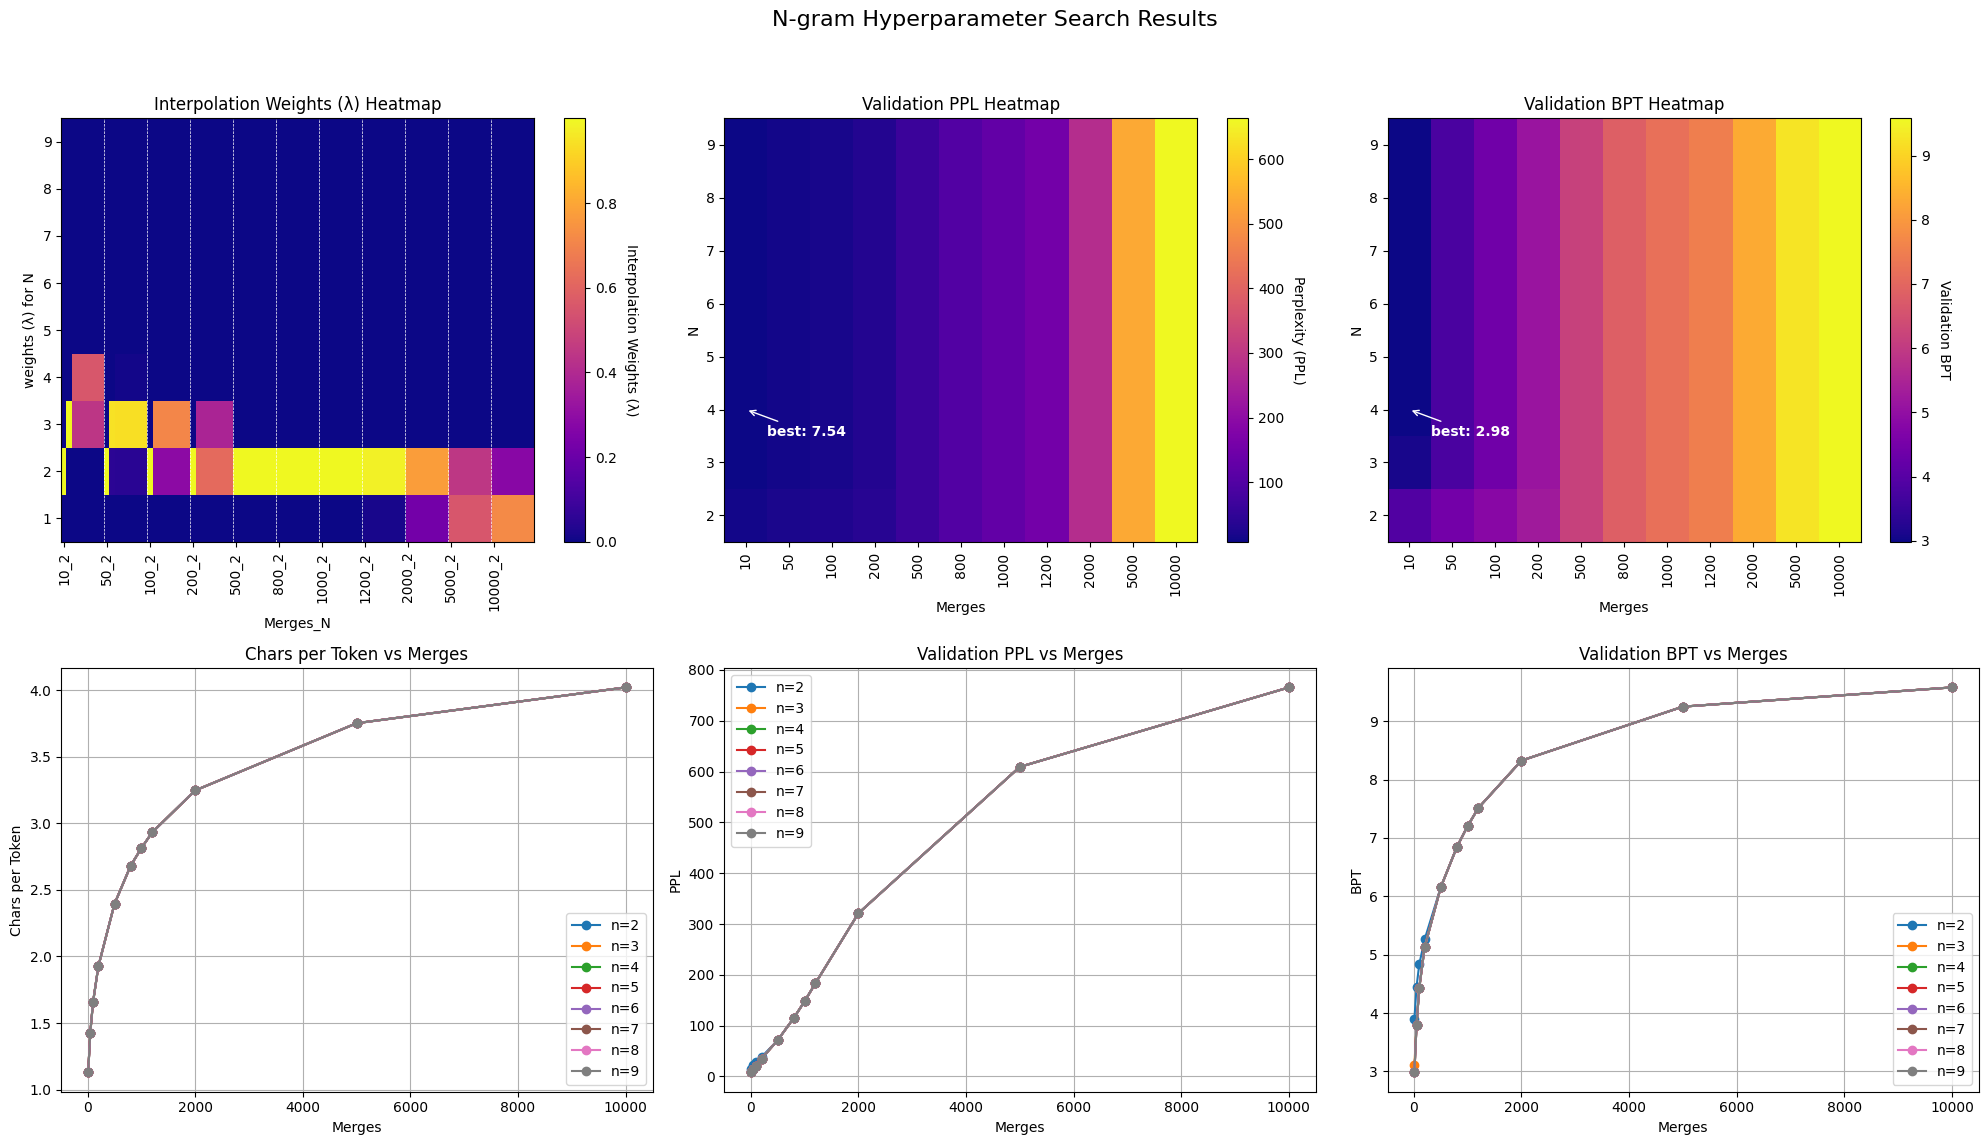

In [28]:
# df = pd.read_csv(os.path.join(NGRAM_RESULTS_DIR, "ngram_hparams_fit_results.csv"))
# # convert lambdas from string to list of floats
# df["best_lambdas"] = df["best_lambdas"].apply(lambda x: [float(i) for i in x.strip("[]").split(",")])

plot_parameter_search_results(df, save_path=os.path.join(NGRAM_RESULTS_DIR, "ngram_hparams_fit_results.png"))

### fit metrics on test data

In [11]:
# run multiple models with different params and tokenizers on held out test data
def fit_ngram_to_test_data(train_file: str,
                           train_text: str,
                           val_text: str,
                           test_text: str,
                            merges: int,
                            n: int,
                            lambdas: list,):
        

    tokenizer = train_bytelevel_bpe(
        files=[train_file],
        merges=merges,
        min_frequency=2,
        lowercase=False,
        add_prefix_space=True,

    )

    # encode train and test sets
    train_ids = tokenizer.encode(train_text).ids
    test_ids = tokenizer.encode(test_text).ids
    val_ids = tokenizer.encode(val_text).ids



    model = NGramEngine(n)
    model.fit(train_ids,
            lambdas=lambdas, 
            pad_token=tokenizer.token_to_id(SPECIAL_TOKENS['bos']) if SPECIAL_TOKENS.get('bos', None) is not None else BOS_TOKEN_ID)


    fit_results_train = model.fit_metrics(train_ids, interpolate=True)
    fit_results_val = model.fit_metrics(val_ids, interpolate=True)
    fit_results_test = model.fit_metrics(test_ids, interpolate=True)

    # generate sample text
    context_text = " ".join(test_text.split()[:3])
    context_text_ids = tokenizer.encode(context_text, add_special_tokens=False).ids
    sample_text_ids = model.generate(
        context_text_ids,
        # max_new_tokens=100,
        max_new_tokens=100,
        mode="sample",
        temperature=0.9,
        top_k=20,
        top_p=None,
        repetition_penalty=0.95,
    )
    sample_text = tokenizer.decode(sample_text_ids)

    print(f"Test set metrics with best params (merges={merges}, n={n}):")
    print(f"lambdas: {lambdas}")
    print(f"train BPT: {fit_results_train['bpt']:.7f}, PPL: {fit_results_train['ppl']:.3f}")
    print(f"Validation BPT: {fit_results_val['bpt']:.7f}, PPL: {fit_results_val['ppl']:.3f}")
    print(f"Test BPT: {fit_results_test['bpt']:.7f}, PPL: {fit_results_test['ppl']:.3f}")
    print("\nSample text generated from the model:")
    print(f"Context: {context_text}")
    print("generated_text: ", sample_text)

    return {
        "tokenizer": tokenizer,
        "model": model,
        "fit_results_train": fit_results_train,
        "fit_results_val": fit_results_val,
        "fit_results_test": fit_results_test,
        "sample_text": sample_text,
        "context_text": context_text
    }

In [13]:
df_ngram_fit_results["best_lambdas"] = df_ngram_fit_results["best_lambdas"].apply(lambda x: [float(i) for i in x.strip("[]").split(",")])

In [14]:
best_ppl_row = df_ngram_fit_results.loc[df_ngram_fit_results["val_ppl"].idxmin()]
best_merges = best_ppl_row["merges"]

# for each merge in n_merges_grid, fit tokenizer and then get the best n and lambdas from df_ngram_fit_results and fit the model
n_merges_grid = [200, 800] + [best_merges]
n_merges_grid = sorted(set(n_merges_grid)) 
all_test_results = []
for merges in n_merges_grid:
    tokenizer = train_bytelevel_bpe(
        files=[train_file],
        merges=merges,
        min_frequency=2,
        lowercase=False,
        add_prefix_space=True,
    )

    subset_df = df_ngram_fit_results[df_ngram_fit_results["merges"] == merges]
    if subset_df.empty:
        print(f"No results found for merges={merges}. Skipping.")
        continue
    best_ppl_row = subset_df.loc[subset_df["val_ppl"].idxmin()]
    best_n = best_ppl_row["n"]  
    best_lambdas = best_ppl_row["best_lambdas"]

    print("#" * 50) 
    if merges == best_merges:
        print(f"**(best fit)** for merges={merges}: results for best n {best_n} and lambdas {best_lambdas}:")
    print(f"for merges={merges}: results for best n {best_n} and lambdas {best_lambdas}:")

    res = fit_ngram_to_test_data(
        train_file=train_file,
        train_text=train_text,
        val_text=val_text,
        test_text=test_text,
        merges=merges,
        n=best_n,
        lambdas=best_lambdas
    )
    all_test_results.append({
        "merges": merges,
        "n": best_n,
        "lambdas": best_lambdas,
        **res
        })




##################################################
**(best fit)** for merges=10: results for best n 4 and lambdas [4.860967526347699e-13, 9.832745968417715e-06, 0.4419580221477753, 0.5580321451057701]:
for merges=10: results for best n 4 and lambdas [4.860967526347699e-13, 9.832745968417715e-06, 0.4419580221477753, 0.5580321451057701]:



Test set metrics with best params (merges=10, n=4):
lambdas: [4.860967526347699e-13, 9.832745968417715e-06, 0.4419580221477753, 0.5580321451057701]
train BPT: 2.9229473, PPL: 7.584
Validation BPT: 2.9903171, PPL: 7.946
Test BPT: 2.9474993, PPL: 7.714

Sample text generated from the model:
Context: or any show
generated_text:   or any show com than heaved: OCT'AMLET O At that maken his cons and is that; good cir it yet but man couldst, That of milky t



##################################################
for merges=200: results for best n 4 and lambdas [3.2528031108462075e-10, 0.618794186858232, 0.3812018020574253, 4.010759062329119e-06]:



Test se

,merges,test_ppl,train_ppl,val_ppl,n,lambdas
0,10,7.714000,7.584000,7.946000,4,"0.000, 0.000, 0.442, 0.558"
1,200,34.605000,32.426000,35.017000,4,"0.000, 0.619, 0.381, 0.000"
2,800,114.638000,100.122000,115.217000,2,"0.000, 1.000"


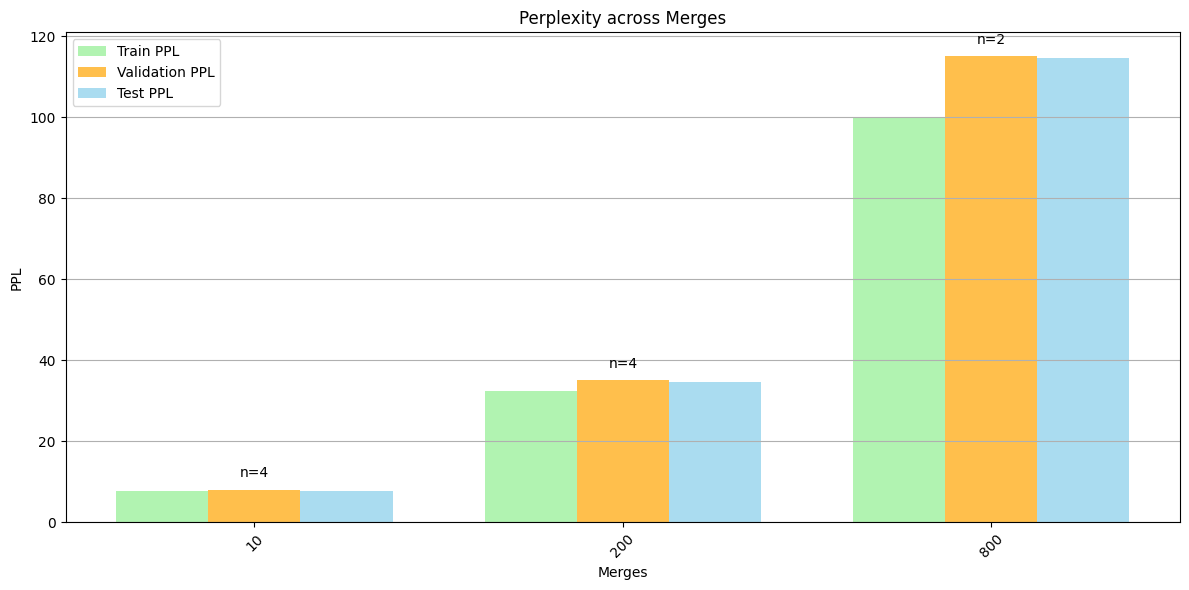


Generated sample texts for each model:
context: 
--  or any show

Generated sample text for merges=10, n=4, lambdas=[4.860967526347699e-13, 9.832745968417715e-06, 0.4419580221477753, 0.5580321451057701]:

--  or any show com than heaved: OCT'AMLET O At that maken his cons and is that; good cir it yet but man couldst, That of milky t

------------------------------------------------------------------------------------------------------------------------

Generated sample text for merges=200, n=4, lambdas=[3.2528031108462075e-10, 0.618794186858232, 0.3812018020574253, 4.010759062329119e-06]:

--  or any shown, to me, That exither. HACBA, Casses, Shens? I minelp, With le, And if I say, When I shall faticalit Some ton the math of maviaptains arthrows, And park to wombs, I throoforr

------------------------------------------------------------------------------------------------------------------------

Generated sample text for merges=800, n=2, lambdas=[8.245760076959627e-06, 0.9999917542

In [15]:
test_results_df = pd.DataFrame(all_test_results)
# pull nested metrics
df_tbl = pd.DataFrame({
    "merges": test_results_df["merges"],
    "test_ppl":  test_results_df["fit_results_test"].apply(lambda d: d["ppl"].round(3)),
    "train_ppl": test_results_df["fit_results_train"].apply(lambda d: d["ppl"].round(3)),
    "val_ppl":   test_results_df["fit_results_val"].apply(lambda d: d["ppl"].round(3)),
    "n":      test_results_df["n"],
    "lambdas": test_results_df["lambdas"],
})

df_tbl = df_tbl.sort_values(["test_ppl", "val_ppl", "train_ppl"], ascending=True).reset_index(drop=True)
df_tbl["lambdas"] = df_tbl["lambdas"].apply(lambda x: [round(v, 4) for v in x])  # round lambdas to 3 decimal places
# display full table, no turning off truncation
display(df_tbl.style
    .set_properties(**{'text-align': 'left'})
    .set_table_styles([{
        'selector': 'th',
        'props': [('text-align', 'left')]
    }])
    .format({
        "lambdas": lambda x: ', '.join(f"{v:.3f}" for v in x)
    })
)
# Extract metrics
train_ppl = test_results_df["fit_results_train"].apply(lambda x: x["ppl"])
val_ppl   = test_results_df["fit_results_val"].apply(lambda x: x["ppl"])
test_ppl  = test_results_df["fit_results_test"].apply(lambda x: x["ppl"])
merges    = test_results_df["merges"].values
n_vals    = test_results_df["n"].values

# Grouped bar positions
x = np.arange(len(merges))   # one x per merge setting
width = 0.25                 # bar width

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, train_ppl, width, label="Train PPL", color="lightgreen", alpha=0.7)
ax.bar(x,         val_ppl,   width, label="Validation PPL", color="orange", alpha=0.7)
ax.bar(x + width, test_ppl,  width, label="Test PPL", color="skyblue", alpha=0.7)

# annotate with n
for i, (xp, y) in enumerate(zip(x, test_ppl)):
    ax.annotate(f"n={n_vals[i]}", (xp, y), textcoords="offset points", xytext=(0,10),
                ha='center', fontsize=10)

ax.set_xticks(x)
ax.set_xticklabels(merges, rotation=45)
ax.set_title("Perplexity across Merges")
ax.set_xlabel("Merges")
ax.set_ylabel("PPL")
ax.grid(True, axis='y')
ax.legend()
plt.tight_layout()
plt.show()

# print the generated sample text for the best model
print("\nGenerated sample texts for each model:")
print("context: \n-- ", all_test_results[0]["context_text"])
for res in all_test_results:
    print(f"\nGenerated sample text for merges={res['merges']}, n={res['n']}, lambdas={res['lambdas']}:")
    print(f"\n-- {res['sample_text']}\n")
    print('-' * 120)


# save table, plot, and written results
os.makedirs(NGRAM_RESULTS_DIR, exist_ok=True)
df_tbl.to_csv(os.path.join(NGRAM_RESULTS_DIR, "ngram_test_results.csv"), index=False)
# save the plot of PPL across merges
fig.savefig(os.path.join(NGRAM_RESULTS_DIR, "ngram_test_results_ppl.png"), bbox_inches='tight')
# save the generated sample texts to a text file
with open(os.path.join(NGRAM_RESULTS_DIR, "ngram_generated_samples.txt"), "w", encoding="utf-8") as f:
    for res in all_test_results:
        f.write(f"Generated sample text for merges={res['merges']}, n={res['n']}, lambdas={res['lambdas']}:\n")
        f.write(f"\n-- {res['sample_text']}\n")
        f.write('-' * 120 + '\n')
    f.write("\nContext for generated samples:\n")
    f.write(f"-- {all_test_results[0]['context_text']}\n")

print(f"Results saved to {NGRAM_RESULTS_DIR}")